# Add the capacity to verify the board

Checking the board visually is fine for debugging but it does not work well if we want to test a lot of board solutions

Goals:
- given a board is it completed ? 
- Are cells left undefined ? 
- Does it holds the clues ?

## Board class from notebook 01

In [59]:
import numpy as np
from enum import Enum

# constants for mark lette
class BoardMark(Enum):
    INIT = -1
    FILLER = 0
    BLACK = 1

class Board:
    '''
    Manage the board.
    '''
    
    def __init__(self, some_clues):
        '''
        board constructor
        '''
        # given parameters
        self.clues = some_clues
        # compute board dimensions
        self.width = len(self.clues['cols']) 
        self.height = len(self.clues['rows']) 
        # create board of type int, initialized with -1
        default_value = BoardMark.INIT.value
        self.states = np.full((self.height, self.width), default_value, dtype=int)
        
    def mark(self, row, col, mark):
        '''
        mark a cell
        '''
        self.states[row, col] = mark.value

    def prettyprint(self):
        '''
        pretty print of the board 
        '''
        print("cols:", end=" ")
        print(*self.clues['cols']) # * unpacks and remove []s
        print("rows:")
        [print(r) for r in self.clues['rows']]
          
        marks_switcher = {-1: '.', 0: 'x', 1: 'o'}
        # for whatever reason lambda does not work here
        def f_marks(v):
            return marks_switcher[v]
        applyall = np.vectorize(f_marks)
        marks = applyall(self.states)
        print(marks)


In [60]:
# clues for mini game
clues = {
    'rows': [1, 2],
    'cols': [2, 1]
}
board = Board(clues)
board.prettyprint()
board.mark(0, 1, BoardMark.FILLER) 
board.mark(1, 1, BoardMark.BLACK) 
board.prettyprint()

cols: 2 1
rows:
1
2
[['.' '.']
 ['.' '.']]
cols: 2 1
rows:
1
2
[['.' 'x']
 ['.' 'o']]


## Get the number of blacks from clues

In [61]:
clues = {
    'rows': [1, 2],
    'cols': [2, 1]
}

In [62]:
total_blacks = sum(clues['rows'])
total_blacks

3

In [63]:
assert total_blacks == 3

In [64]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [65]:
# this does work for split blocks like above
# assert sum(clues['rows']) == 3
# the mix of integers and list results in an error
# TypeError: unsupported operand type(s) for +: 'int' and 'list'

## Normalize the clues 

Summing or scanning the clues in a consistent way is required for a lot of features (check for consistency, check whether given clues and computed fromthe board are the same).

We can transform the user-friendly list into a computer-friendly list 

In [66]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [67]:
# convert all integers into a list of one integer
f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
[f_norm_clue(clue) for clue in [1, 3, [1,1], 3, 5]]

[[1], [3], [1, 1], [3], [5]]

In [68]:
# norm clues
def get_norm_clues(some_clues):
    f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
    norm_clues = {
        'rows': [f_norm_clue(clue) for clue in some_clues['rows']],
        'cols': [f_norm_clue(clue) for clue in some_clues['cols']]
    }
    return norm_clues
get_norm_clues(clues)

{'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]}

In [69]:
assert get_norm_clues(clues) == {'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]} 

Does it still work for non split ?

In [70]:
clues = {
    'rows': [1, 2],
    'cols': [2, 1]
}

In [71]:
assert get_norm_clues(clues) == {'rows': [[1], [2]], 'cols': [[2], [1]]}

## Get number of blacks - split tolerant

Now we can compute the sum a consistent way

In [72]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [73]:
#total_blacks = sum(get_norm_clues(clues)['rows'])
#total_blacks
# results in an error because it cannot sum ints with lists

In [74]:
from itertools import chain
list(chain.from_iterable(get_norm_clues(clues)['rows']))

[1, 3, 1, 1, 3, 5]

In [75]:
from itertools import chain
def get_total_blacks(some_norm_clues, axis='rows'):
    return sum(chain.from_iterable(some_norm_clues[axis]))
norm_clues = get_norm_clues(clues)
total_blacks = get_total_blacks(norm_clues)
total_blacks

14

In [76]:
assert total_blacks == 14

In [77]:
assert get_total_blacks(norm_clues, axis='cols') == 14

In [78]:
## Check clues for consistency

In [79]:
# number of blacks on rows and cols miust be the same
assert get_total_blacks(norm_clues, axis='rows') == get_total_blacks(norm_clues, axis='cols')

## check numbers of cells left empty

Check for undefined cells existence

In [80]:
# clues for mini game
clues = {
    'rows': [1, 2],
    'cols': [2, 1]
}
board = Board(clues)
board.mark(0, 1, BoardMark.FILLER) 
board.mark(1, 1, BoardMark.BLACK) 
board.prettyprint()

cols: 2 1
rows:
1
2
[['.' 'x']
 ['.' 'o']]


In [81]:
# filter the cells having an undegined value 
# reshaping in a list of lenght equald to the number of cells 
# avoid having to browse a list of lists
[ c for c in board.states.reshape(4) if c == -1]

[-1, -1]

In [82]:
board.states.shape

(2, 2)

In [83]:
from operator import mul
from functools import reduce
reduce(mul, board.states.shape)

4

TODO explain reduce

In [84]:
from operator import mul
from functools import reduce

def count_empty(a_board):
    length = reduce(mul, a_board.states.shape)
    count = len([ c for c in a_board.states.reshape(length) 
                         if c == -1])
    return count
  
count = count_empty(board)
print(f"count_empty={count}")
assert count == 2

count_empty=2


Check for 5x5

In [85]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [86]:
board = Board(clues)
board.mark(4, 0, BoardMark.BLACK) 
board.mark(2, 2, BoardMark.FILLER) 
board.prettyprint()
count = count_empty(board)
print(f"count_empty={count}")
assert count == reduce(mul, board.states.shape) - 2

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
count_empty=23


## Check whether board hold the clues

In [87]:
# clues for mini game
clues = {
    'rows': [1, 2],
    'cols': [2, 1]
}
norm_clues = get_norm_clues(clues)
board = Board(clues)
board.prettyprint()
board.mark(0, 0, BoardMark.BLACK) 
board.mark(0, 1, BoardMark.FILLER) 
board.mark(1, 0, BoardMark.BLACK) 
board.mark(1, 1, BoardMark.BLACK) 
board.prettyprint()

cols: 2 1
rows:
1
2
[['.' '.']
 ['.' '.']]
cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [88]:
rows = board.states
rows

array([[1, 0],
       [1, 1]])

In [89]:
from itertools import groupby

In [90]:
# group cells by value and select groups where group key is 1 (BLACK)
[ [(k, *g) for k,g in groupby(line) if k==1]
  for line in rows
]
# it outputs tuples where the first element is the key, 
# and the rest are the elements in the 
# there are two list (one for each row)
# row 0 : has 1 black cell (1=BLACK key, 1=the cell)
# row 1 : has 2 black cells (1=BLACK key, 1,1=the cells)

[[(1, 1)], [(1, 1, 1)]]

In [91]:
# transform to a list of block length
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
]
print(f"blocks={blocks}")
assert blocks == norm_clues['rows'] 

blocks=[[1], [2]]


In [92]:
assert blocks == norm_clues['rows'] 

In [93]:
w = board.states.shape[0]
h = board.states.shape[1]
length = mul(w, h)
cols = [ [board.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
cols

[[1, 1], [0, 1]]

In [94]:
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
  for line in cols
]
print(f"blocks={blocks}")
assert blocks == norm_clues['cols'] 

blocks=[[2], [1]]


In [95]:
def get_rows_blocks(a_board):
    rows = a_board.states
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
    ]
    return blocks

def get_cols_blocks(a_board):
    w = a_board.states.shape[0]
    h = a_board.states.shape[1]
    length = mul(w, h)
    cols = [ [a_board.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
      for line in cols
    ]
    return blocks

In [96]:
assert get_rows_blocks(board) == norm_clues['rows'] 

In [97]:
assert get_cols_blocks(board)  == norm_clues['cols'] 

In [98]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}
board = Board(clues)
board.mark(4, 0, BoardMark.BLACK) 
board.mark(2, 2, BoardMark.FILLER) 
board.prettyprint()
count = count_empty(board)
print(f"blocks={blocks}")


cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
blocks=[[2], [1]]


In [99]:
get_rows_blocks(board)

[[], [], [], [], [1]]

In [100]:
# 1 BLACK on row 4
assert get_rows_blocks(board) == [[], [], [], [], [1]]

In [101]:
get_cols_blocks(board)

[[1], [], [], [], []]

In [102]:
# 1 BLACK on col 0
assert get_cols_blocks(board) == [[1], [], [], [], []]

## updated classes - utilsv2

In [103]:
%reset -f

Some solver will do operations on clues without having a board. For instance evaluate the total number of blacks cells in order to randomly place an equal nulber of blacks.

The game rules must be a separate class.

In [104]:
### New Puzzle class

In [105]:
from itertools import chain

class Puzzle:
    ''' Define the game clues and constants'''
    
    def __init__(self, some_clues):
        '''
        puzzle constructor
        '''
        # given parameters
        self.given_clues = some_clues
        
        # normalize clues
        self.norm_clues = self.init_norm_clues()
        
        # compute board dimensions
        self.width = len(some_clues['cols']) 
        self.height = len(some_clues['rows']) 
        self.cells_count = self.width * self.height
        self.required_blacks_count = self.get_black_count()
        
        
    def init_norm_clues(self):
        f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
        norm_clues = {
            'rows': [f_norm_clue(clue) for clue in self.given_clues['rows']],
            'cols': [f_norm_clue(clue) for clue in self.given_clues['cols']]
        }
        return norm_clues

    def get_black_count(self, axis='rows'):
        return sum(chain.from_iterable(self.norm_clues[axis]))
      
    def is_valid(self):
        return self.get_black_count(axis='rows') == self.get_black_count(axis='cols')

Tests

In [106]:
clues1 = {
    'rows': [1, 2],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
assert puzzle1.required_blacks_count == 3
assert puzzle1.norm_clues == {'rows': [[1], [2]], 
                              'cols': [[2], [1]]}
assert puzzle1.is_valid()

In [107]:
clues1 = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}
puzzle1 = Puzzle(clues1)
assert puzzle1.required_blacks_count == 14
assert puzzle1.norm_clues == {'rows': [[1], [3], [1, 1], [3], [5]], 
                              'cols': [[1], [4], [2, 2], [4], [1]]} 
assert puzzle1.is_valid()

In [108]:
# inbalanced clues
clues1 = {
    'rows': [1, 1],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
print(f"blacks in rows={puzzle1.get_black_count(axis='rows')}")
print(f"blacks in cols={puzzle1.get_black_count(axis='cols')}")
assert not puzzle1.is_valid()

blacks in rows=2
blacks in cols=3


### Changes to the Board class

In [121]:
import numpy as np
from enum import Enum
from itertools import groupby, chain
from operator import mul
from functools import reduce

# constants for mark lette
class BoardMark(Enum):
    INIT = -1
    FILLER = 0
    BLACK = 1

class Board:
    '''
    Manage the board.
    '''
    
    def __init__(self, some_puzzle):
        '''
        board constructor
        '''
        # given parameters
        self.puzzle = some_puzzle
        
        # compute board dimensions
        self.width = some_puzzle.width
        self.height = some_puzzle.height
        self.cells_count = some_puzzle.cells_count
        
        # create board of type int, initialized with -1
        default_value = BoardMark.INIT.value
        self.states = np.full((self.height, self.width), default_value, dtype=int)
            
    def mark(self, row, col, mark):
        '''
        mark a cell
        '''
        self.states[row, col] = mark.value

    def prettyprint(self):
        '''
        pretty print of the board 
        '''
        print("cols:", end=" ")
        print(*self.puzzle.given_clues['cols']) # * unpacks and remove []s
        print("rows:")
        [print(r) for r in self.puzzle.given_clues['rows']]
          
        marks_switcher = {-1: '.', 0: 'x', 1: 'o'}
        # for whatever reason lambda does not work here
        def f_marks(v):
            return marks_switcher[v]
        applyall = np.vectorize(f_marks)
        marks = applyall(self.states)
        print(marks)

    def is_done(self):
        done = True
        if done:
            done = self.count_empty() == 0
        if done:
            done = self.get_rows_blocks() == self.puzzle.norm_clues['rows']
        if done:
            done = self.get_cols_blocks() == self.puzzle.norm_clues['cols']
        return done

    def count_empty(self):
        length = reduce(mul, self.states.shape)
        count = len([ c for c in self.states.reshape(length) 
                             if c == -1])
        return count    
    
    def get_rows_blocks(self):
        rows = self.states
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
               for line in rows
        ]
        return blocks

    def get_cols_blocks(self):
        w = self.states.shape[0]
        h = self.states.shape[1]
        length = mul(w, h)
        cols = [ [self.states.reshape(length)[c+r*w]
             for r in range(0, h)]
             for c in range(0, w)]
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
          for line in cols
        ]
        return blocks

In [122]:
# clues for mini game
clues1 = {
    'rows': [1, 2],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)
board1.mark(0, 0, BoardMark.BLACK) 
board1.mark(0, 1, BoardMark.FILLER) 
assert board1.count_empty() == 2
board1.mark(1, 0, BoardMark.BLACK) 
board1.mark(1, 1, BoardMark.BLACK) 
board1.prettyprint()
assert board1.is_done() 

cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [120]:
clues1 = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)

# row 4 is ooooo - only option for 5
board1.states[4, :] = BoardMark.BLACK.value
# col 2 is ooxoo - only option for [2, 2]
board1.states[:, 2] = BoardMark.BLACK.value
board1.states[2, 2] = BoardMark.FILLER.value
# col 1 and 3 are xoooo - continguous to the placed black
board1.states[:, 1] = BoardMark.BLACK.value
board1.states[0, 1] = BoardMark.FILLER.value
board1.states[:, 3] = BoardMark.BLACK.value
board1.states[0, 3] = BoardMark.FILLER.value
# rows 1 and 3 are xooox - 3 blacks are placed
board1.states[1, 0] = BoardMark.FILLER.value
board1.states[1, 4] = BoardMark.FILLER.value
board1.states[3, 0] = BoardMark.FILLER.value
board1.states[3, 4] = BoardMark.FILLER.value
# row 2 is xoxox - [1, 1] blacks are placed
board1.states[2, 0] = BoardMark.FILLER.value
board1.states[2, 4] = BoardMark.FILLER.value
assert board1.count_empty() == 2
# row 0 is xoxox - 1 black is placed
board1.states[0, 0] = BoardMark.FILLER.value
board1.states[0, 4] = BoardMark.FILLER.value

board1.prettyprint()
assert board1.is_done() 

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['x' 'x' 'o' 'x' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['x' 'o' 'x' 'o' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o']]


TODO check wrong

### Adapt plotter

In [112]:
from boardutilsv2 import Board, BoardMark
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

class BoardPlotter:
    '''
    Plot the board
    Requiere %matplotlib inline .
    '''
    cdict = {'red': [(0.0, 0.6196078431372549, 0.6196078431372549),
      (0.5, 1.0, 1.0),
      (1.0, 0.03137254901960784, 0.03137254901960784)],
     'green': [(0.0, 0.792156862745098, 0.792156862745098),
      (0.5, 1.0, 1.0),
      (1.0, 0.18823529411764706, 0.18823529411764706)],
     'blue': [(0.0, 0.8823529411764706, 0.8823529411764706),
      (0.5, 1.0, 1.0),
      (1.0, 0.4196078431372549, 0.4196078431372549)],
     'alpha': [(0.0, 1.0, 1.0),
      (0.5, 1.0, 1.0),
      (1.0, 1.0, 1.0)]}
    nono_cmap = LinearSegmentedColormap('nono', cdict)
    
    def __init__(self, a_board):
        self.board = a_board
        self.clues = self.board.puzzle.given_clues
      
        def row_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else ' '.join(map(str,v))
        self.rows_labels = list(map(row_clue_to_label, self.clues['rows']))

        def col_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else '\n'.join(map(str,v))
        self.cols_labels = list(map(col_clue_to_label, self.clues['cols']))
    
    def show(self):
        # WARNING :  the board is row col, while the fig is col row
        data = self.board.states
        w = self.board.width
        h = self.board.height
        nc = self.board.width * self.board.height
        
        # set some canvas
        # guess the figure size 
        # 1 fits 2 cells
        # 2 fits 5 cols
        figw = int(w/2) 
        figh = int(h/2) 
        fig, ax = plt.subplots(figsize=(figw,figh))
        # draw a heatmap
        # ensure value range is -1 to 1
        heatmap = ax.pcolor(data, cmap=self.nono_cmap, vmin=-1, vmax=1)

        # ensure square cells
        ax.set_aspect("equal")

        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

        # put labels on top
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        

        # set labels
        column_labels = self.clues['cols']
        row_labels = self.clues['rows']

        ax.set_xticklabels(self.cols_labels, minor=False)
        ax.set_yticklabels(self.rows_labels, minor=False)


        # annotate fillers
        # expect (col,row) is (1,0) for row=0 col=1
        fillers_coordinates = [(p%w + 0.5, int(p/w) + 0.5) 
                               for (p,v) in enumerate(data.reshape(nc)) 
                               if v==0]
        # place an X in the center of each coordinate
        for coord in fillers_coordinates:
            plt.text(coord[0], coord[1], 'x', 
                 verticalalignment='center',
                 horizontalalignment='center',
                 fontsize='xx-large')

        plt.show()

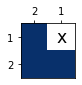

In [123]:
# clues for mini game
clues1 = {
    'rows': [1, 2],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)
plotter1 = BoardPlotter(board1)

board1.mark(0, 0, BoardMark.BLACK) 
board1.mark(0, 1, BoardMark.FILLER) 
board1.mark(1, 0, BoardMark.BLACK) 
board1.mark(1, 1, BoardMark.BLACK) 

assert board1.is_done()
plotter1.show()

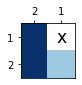

In [124]:
# clues for not complete
clues1 = {
    'rows': [1, 2],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)
plotter1 = BoardPlotter(board1)

board1.mark(0, 0, BoardMark.BLACK) 
board1.mark(0, 1, BoardMark.FILLER) 
board1.mark(1, 0, BoardMark.BLACK) 
#board1.mark(1, 1, BoardMark.BLACK) 

assert not board1.is_done()
plotter1.show()

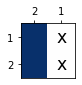

In [125]:
# clues for not complete
clues1 = {
    'rows': [1, 2],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)
plotter1 = BoardPlotter(board1)

board1.mark(0, 0, BoardMark.BLACK) 
board1.mark(0, 1, BoardMark.FILLER) 
board1.mark(1, 0, BoardMark.BLACK) 
board1.mark(1, 1, BoardMark.FILLER)  # wrong

assert not board1.is_done()
plotter1.show()

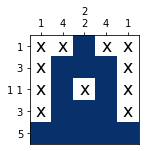

In [114]:
clues1 = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}
puzzle1 = Puzzle(clues1)
board1 = Board(puzzle1)
plotter1 = BoardPlotter(board1)

# row 4 is ooooo - only option for 5
board1.states[4, :] = BoardMark.BLACK.value
# col 2 is ooxoo - only option for [2, 2]
board1.states[:, 2] = BoardMark.BLACK.value
board1.states[2, 2] = BoardMark.FILLER.value
# col 1 and 3 are xoooo - continguous to the placed black
board1.states[:, 1] = BoardMark.BLACK.value
board1.states[0, 1] = BoardMark.FILLER.value
board1.states[:, 3] = BoardMark.BLACK.value
board1.states[0, 3] = BoardMark.FILLER.value
# rows 1 and 3 are xooox - 3 blacks are placed
board1.states[1, 0] = BoardMark.FILLER.value
board1.states[1, 4] = BoardMark.FILLER.value
board1.states[3, 0] = BoardMark.FILLER.value
board1.states[3, 4] = BoardMark.FILLER.value
# row 2 is xoxox - [1, 1] blacks are placed
board1.states[2, 0] = BoardMark.FILLER.value
board1.states[2, 4] = BoardMark.FILLER.value
# row 0 is xoxox - 1 black is placed
board1.states[0, 0] = BoardMark.FILLER.value
board1.states[0, 4] = BoardMark.FILLER.value

assert board1.is_done()
plotter1.show()